# Visualize arbitrary SELECTED_OUTPUT files

The RO PHREEQC simulations generate text files of data. The following code imports the text files, intelligently parses the data, and creates visualizations of the data based upon the user intentions of investigating Brine or Scaling. The Brine outputs are a data table of average elemental concentrations at each time interval of the output file. The Scaling outputs are a figure that depicts the moles of scale that exist over the RO module for each time interval. The output figures can then be exported in the user-selected format and saved in the save user directory as this code file.

What is the name of the SELECTED_OUTPUT file?
Exclude the < .txt > suffix to the file name.Test_with_ethan, Scaling
Which database is employed in the simulation data?
        < pitzer > or < phreeqc >pitzer
Would you like to view the output brine or the module scaling?
        < Brine > or < Scaling >Scaling
Quantity of precipitated minerals: 4
Would you like to plot each mineral on a separate figure?
        The default = < y >
        < y > or < n >n


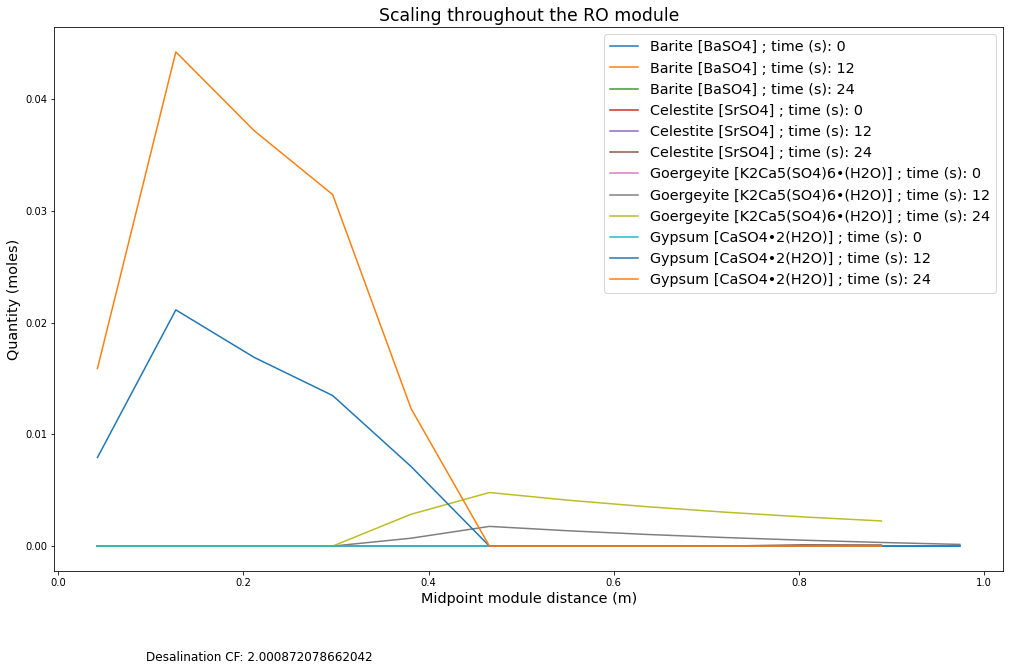

Would you like to export the figure?
            < y > or < n >n
done
====


In [11]:
#import libraries
import pandas
import matplotlib.pyplot as pyplot
import re
import os


#import the SELECTED_OUTPUT file   
basic_file_name = input('''What is the name of the SELECTED_OUTPUT file?
Exclude the < .txt > suffix to the file name.''')
while re.search('(\.txt)', basic_file_name):
    print('ERROR: The < .txt > suffix must be removed from the file name.')  
    file_name = input('What is the name of the SELECTED_OUTPUT file?')
file_name = basic_file_name  + '.txt'
while not os.path.exists(file_name):
    print('ERROR: The SELECTED_OUTPUT file is missing from the current directory.')  
    basic_file_name = input('What is the name of the SELECTED_OUTPUT file?')  
    file_name = basic_file_name  + '.txt'
    
#preparing the SELECTED_OUTPUT file into a dataframe
original_data = pandas.read_table(file_name,sep = '\t')
csv_data = pandas.DataFrame(original_data)
for column in csv_data.columns:
    new_column = column.strip()
    csv_data.rename(columns={column:new_column}, inplace = True)  
    
    
initial_solution_mass = csv_data.at[0, 'mass_H2O']
final_solution_mass = csv_data['mass_H2O'].iloc[-1]
simulation_cf = initial_solution_mass / final_solution_mass
           
        
#===============================================================================================================
        
def make_brine_plot():
    global figure
    
    elements = []
    for column in csv_data.columns:
        if re.search('([A-Z][a-z]?(\(\d\))?){1}$', column) and not re.search('(_|H2O|pH)', column):
            elements.append(column)

    csv_data.drop(csv_data.index[:3], inplace=True)

    
    #plot the brine concentrations figure
    unit = 'mol/kgw'
    concentration_array = []
    pyplot.figure(figsize = (17,10))
    pyplot.title('Effluent brine elemental concentrations', fontsize = 'xx-large')
    pyplot.xlabel('time (s)', fontsize = 'x-large')
    pyplot.ylabel('concentration (%s)' %(unit), fontsize = 'x-large')
    pyplot.grid(True)
    
    for element in elements:  
        concentration_serie = []
        time_serie = []
        initial_solution_time = 0
        for index, row in csv_data.iterrows():
            if csv_data.at[index, 'Cl'] == 0:
                initial_solution_time += 1
                #print('yes')
                
            else:
                concentration_serie.append(csv_data.at[index, element])
                time_serie.append(csv_data.at[index, 'time'] - initial_solution_time)
                
        pyplot.plot(time_serie,concentration_serie)

    plot_caption = '''\n\nBrine Figure:\n%s 
    The effluent brine concentrations of each existing element. Scaling data through the Brine plotting will
    generate vertical concentrations at each defined time. The veritical concentrations represent the concentration
    distributions throughout the RO module at the specified time, where the low boundary is the concentration at
    the entrance of the module while the high boundary is the concentration at the exit of the module.''' %('='*len('Brine Figure'))

    pyplot.legend(elements, loc='best', title = 'non-zero elements', fontsize = 'x-large')
    pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(simulation_cf), wrap=True, horizontalalignment='left', fontsize=12)
    pyplot.yscale('log')
    figure = pyplot.gcf()
    pyplot.show()
    print(plot_caption)

    
    #define a summarizing table of the concentration averages
    loop_iteration = 1
    table_view = {}
    average_concentrations_table = pandas.DataFrame()
    if simulation_perspective == 'Scaling':
        for element in elements:
            quantity_of_steps_index = 0
            average_iteration = 1
            time_serie = []            
            time_averages = {}
            for index, row in csv_data.iterrows():
                if csv_data.at[index, 'time'] == 0:
                    time_serie.append(csv_data.at[index,element])                 
                    quantity_of_steps_index += 1                    

                elif csv_data.at[index-1,'soln'] == quantity_of_steps_index:       
                    #process the complete time serie
                    try:
                        average_concentration = sum(time_serie) / len(time_serie)
                    except:
                        average_concentration = 0
                    #print(average_concentration)
                    table_view['Time: %s' %(average_iteration)] = {}
                    table_view['Time: %s' %(average_iteration)][element] = [average_concentration]
                    average_iteration += 1
                    #print('mid-End')   

                    #begin the new time serie
                    time_serie = []
                    time_averages = {}
                    time_serie.append(csv_data.at[index,element])
                    #print('middle')    

                elif index == len(csv_data[element]) + 2:       
                    time_serie.append(csv_data.at[index,element])            
                    try:
                        average_concentration = sum(time_serie) / len(time_serie)
                    except:
                        average_concentration = 0
                    table_view['Time: %s' %(average_iteration)] = {}
                    table_view['Time: %s' %(average_iteration)][element] = [average_concentration]
                    average_iteration += 1
                    #print('end-End')  

                    average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
                    loop_iteration += 1

                else:
                    #print('middle')      
                    time_serie.append(csv_data.at[index,element])
        
    if simulation_perspective == 'Brine':
        for element in elements:  
            concentration_serie = []
            time_serie = []
            for index, row in csv_data.iterrows():
                if csv_data.at[index, 'Cl'] != 0:
                    concentration_serie.append(csv_data.at[index,element])      

            average_concentration = sum(concentration_serie) / len(concentration_serie)
            table_view['%s' %(element)] = average_concentration

        average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
        average_concentrations_table.rename(index = {0:'Concentrations (molal)'}, inplace = True)
    
    total_time = csv_data['time'].iloc[-1]
    dataframe_title = 'Average elemental molal concentrations of the feed water in the RO module over %s seconds of simulation:' %(total_time)
    print('\n\n\n',dataframe_title,'\n%s'%('='*len(dataframe_title)))
    display(average_concentrations_table)

        
    #export the output graphic
    export_option = input('''Would you like to export the figure?
    < y > or < n >''')
    if export_option == 'y':
        export_plot()
    elif export_option == 'n':
        final_message = 'The data processing is complete.'
        print('%s\n%s' %(final_message, '='*len(final_message)))
    else:
        while export_option != 'y' and export_option != 'n':
            print('''ERROR: The value is not one of the options.''')  
            export_option = input('''Would you like to export the figure?
            < y > or < n >''')
        
        

#===============================================================================================================        

    
def make_scaling_plot():
    global individual_plots
    global mineral
    global figure
    
    if database == 'pitzer':
        minerals = ['Akermanite', 'Anhydrite', 'Anthophyllite', 'Antigorite', 'Aragonite', 'Arcanite', 'Artinite',
                           'Barite', 'Bischofite', 'Bloedite', 'Brucite', 'Burkeite', 'Calcite', 'Carnallite', 'Celestite',
                           'Chalcedony', 'Chrysotile', 'Diopside', 'Dolomite', 'Enstatite', 'Epsomite', 'Forsterite',
                           'Gaylussite', 'Glaserite', 'Glauberite', 'Goergeyite', 'Gypsum', 'Halite', 'Hexahydrite', 'Huntite', 'Kainite',
                           'Kalicinite', 'Kieserite', 'Labile_S', 'Leonhardite', 'Leonite', 'Magnesite', 'MgCl2_2H2O',
                           'MgCl2_4H2O', 'Mirabilite', 'Misenite', 'Nahcolite', 'Natron', 'Nesquehonite', 'Pentahydrite', 
                           'Pirssonite', 'Polyhalite', 'Portlandite', 'Quartz', 'Schoenite', 'Sepiolite(d)', 'Sepiolite', 
                           'SiO2(a)', 'Sylvite','Syngenite', 'Talc', 'Thenardite', 'Trona', 'Borax', 'Boric_acid,s', 
                           'KB5O8:4H2O', 'K2B4O7:4H2O', 'NaBO2:4H2O', 'NaB5O8:5H2O', 'Teepleite']
        mineral_formulas = ['Ca2Mg[Si2O7]', 'CaSO4', '☐Mg2Mg5Si8O22(OH)2', 'Mg48Si34O85(OH)62', 'CaCO3', 'K2SO4', 'Mg2(CO3)(OH)2·3H2O',
                                  'BaSO4', 'MgCl2·6H2O', 'Na2Mg(SO4)2·4H2O', 'Mg(OH)2', 'Na6(CO3)(SO4)2', 'CaCO3', 'KMgCl3•6(H2O)', 'SrSO4',
                                  'SiO2', 'Mg3Si2O5(OH)4', 'CaMgSi2O6', 'CaMg(CO3)2', 'MgSiO3', 'MgSO4•7(H2O)', 'Mg2SiO4',
                                  'Na2Ca(CO3)2•5(H2O)', 'NaK3(SO4)2', 'Na2Ca(SO4)2', 'K2Ca5(SO4)6•(H2O)', 'CaSO4•2(H2O)', 'NaCl', 'MgSO4•6(H2O)', 'CaMg3(CO3)4', 'MgSO4•KCl•3(H2O)',
                                  'KHCO3', 'MgSO4•(H2O)', 'Na4Ca(SO4)3•2H2O', 'MgSO4•4(H2O)', 'K2Mg(SO4)2•4(H2O)', 'MgCO3', 'MgCl2:2H2O',
                                  'MgCl2•4H2O', 'Na2SO4•10(H2O)', 'K8H6(SO4)7', 'NaHCO3', 'Na2CO3•10(H2O)', 'Mg(HCO3)(OH)•2(H2O)', 'MgSO4•5(H2O)',
                                  'Na2Ca(CO3)2•2(H2O)', 'K2Ca2Mg(SO4)4•2(H2O)', 'Ca(OH)2', 'SiO2', 'K2Mg(SO4)2•6(H2O)', 'Mg4Si6O15(OH)2•6(H2O)', 'Mg4Si6O15(OH)2•6(H2O)',
                                  'SiO2', 'KCl', 'K2Ca(SO4)2•(H2O)', 'Mg3Si4O10(OH)2', 'Na2SO4', 'Na3(CO3)(HCO3)•2(H2O)', 'Na2B4O5(OH)4•8(H2O)', 'B(OH)3',
                                  'KB5O8•4H2O', 'K2B4O7•4H2O', 'NaBO2•4H2O', 'NaB5O8•5H2O', 'Na2B(OH)4Cl']     
    
    
    if database == 'phreeqc':
        minerals = ['Akermanite', 'Anhydrite', 'Anthophyllite', 'Antigorite', 'Aragonite', 'Arcanite', 'Artinite',
                           'Barite', 'Bischofite', 'Bloedite', 'Brucite', 'Burkeite', 'Calcite', 'Carnallite', 'Celestite',
                           'Chalcedony', 'Chrysotile', 'Diopside', 'Dolomite', 'Enstatite', 'Epsomite', 'Forsterite',
                           'Gaylussite', 'Glaserite', 'Glauberite', 'Goergeyite', 'Gypsum', 'Halite', 'Hexahydrite', 'Huntite', 'Kainite',
                           'Kalicinite', 'Kieserite', 'Labile_S', 'Leonhardite', 'Leonite', 'Magnesite', 'MgCl2_2H2O',
                           'MgCl2_4H2O', 'Mirabilite', 'Misenite', 'Nahcolite', 'Natron', 'Nesquehonite', 'Pentahydrite', 
                           'Pirssonite', 'Polyhalite', 'Portlandite', 'Quartz', 'Schoenite', 'Sepiolite(d)', 'Sepiolite', 
                           'SiO2(a)', 'Sylvite','Syngenite', 'Talc', 'Thenardite', 'Trona', 'Borax', 'Boric_acid,s', 
                           'KB5O8:4H2O', 'K2B4O7:4H2O', 'NaBO2:4H2O', 'NaB5O8:5H2O', 'Teepleite']
        mineral_formulas = ['Ca2Mg[Si2O7]', 'CaSO4', '☐Mg2Mg5Si8O22(OH)2', 'Mg48Si34O85(OH)62', 'CaCO3', 'K2SO4', 'Mg2(CO3)(OH)2·3H2O',
                                  'BaSO4', 'MgCl2·6H2O', 'Na2Mg(SO4)2·4H2O', 'Mg(OH)2', 'Na6(CO3)(SO4)2', 'CaCO3', 'KMgCl3•6(H2O)', 'SrSO4',
                                  'SiO2', 'Mg3Si2O5(OH)4', 'CaMgSi2O6', 'CaMg(CO3)2', 'MgSiO3', 'MgSO4•7(H2O)', 'Mg2SiO4',
                                  'Na2Ca(CO3)2•5(H2O)', 'NaK3(SO4)2', 'Na2Ca(SO4)2', 'K2Ca5(SO4)6•(H2O)', 'CaSO4•2(H2O)', 'NaCl', 'MgSO4•6(H2O)', 'CaMg3(CO3)4', 'MgSO4•KCl•3(H2O)',
                                  'KHCO3', 'MgSO4•(H2O)', 'Na4Ca(SO4)3•2H2O', 'MgSO4•4(H2O)', 'K2Mg(SO4)2•4(H2O)', 'MgCO3', 'MgCl2:2H2O',
                                  'MgCl2•4H2O', 'Na2SO4•10(H2O)', 'K8H6(SO4)7', 'NaHCO3', 'Na2CO3•10(H2O)', 'Mg(HCO3)(OH)•2(H2O)', 'MgSO4•5(H2O)',
                                  'Na2Ca(CO3)2•2(H2O)', 'K2Ca2Mg(SO4)4•2(H2O)', 'Ca(OH)2', 'SiO2', 'K2Mg(SO4)2•6(H2O)', 'Mg4Si6O15(OH)2•6(H2O)', 'Mg4Si6O15(OH)2•6(H2O)',
                                  'SiO2', 'KCl', 'K2Ca(SO4)2•(H2O)', 'Mg3Si4O10(OH)2', 'Na2SO4', 'Na3(CO3)(HCO3)•2(H2O)', 'Na2B4O5(OH)4•8(H2O)', 'B(OH)3',
                                  'KB5O8•4H2O', 'K2B4O7•4H2O', 'NaBO2•4H2O', 'NaB5O8•5H2O', 'Na2B(OH)4Cl']     
    
    #the complete list of all minerals is created
    minerals = []
    for column in csv_data.columns:
        if re.search('([A-Z].{3,})', column) and not re.search('(\(|\_|\:)', column):
            minerals.append(column)

    csv_data.drop(csv_data.index[:3], inplace=True)

    #all of the non-zero minerals are identified
    non_zero_minerals = []
    for mineral in minerals:
        for row in csv_data[mineral]:
            if row != 0 and mineral not in non_zero_minerals:
                non_zero_minerals.append(mineral)
    quantity_nonzero_minerals = len(non_zero_minerals)
            
                
    #the chemical formulas for all non-zero minerals is stored in a list
    non_zero_mineral_formulas = []
    for mineral in non_zero_minerals:
        mineral_index = minerals.index(mineral)
        mineral_formula = mineral_formulas[mineral_index]
        non_zero_mineral_formulas.append(mineral_formula)      
        
    unit = 'moles'

    #plot the simulation depending upon the simulation perspective
    if simulation_perspective == "Brine":
        individual_plots = 'n'
        pyplot.figure(figsize = (17,10))
        pyplot.title('Scaling at the last discretization of the RO module', fontsize = 'xx-large')
        pyplot.xlabel('Simulation time (s)', fontsize = 'x-large')
        pyplot.ylabel('Quantity (%s)' %(unit), fontsize = 'x-large')  
        experimental_loop = []
        for mineral in non_zero_minerals:
            mineral_serie = []
            time_serie = []
            #print(mineral)
            for index, row in csv_data.iterrows():
                #print('yes')
                mineral_serie.append(csv_data.at[index, mineral]) 
                time = csv_data.at[index, 'time']
                time_serie.append(time)

            pyplot.plot(time_serie,mineral_serie)
            pyplot.scatter(time_serie,mineral_serie)

            experimental_loop.append('%s [%s]' %(mineral,mineral_formulas[minerals.index(mineral)]))        
        pyplot.legend(experimental_loop, loc='best', fontsize = 'x-large')
        pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(simulation_cf), wrap=True, horizontalalignment='left', fontsize=12)
        figure = pyplot.gcf()
        pyplot.show()
        
        export_option = input('''Would you like to export the figure?
        < y > or < n >''')
        if export_option == 'y':
            export_plot()
        elif export_option == 'n':
            final_message = 'The data processing is complete.'
            print('%s\n%s' %(final_message, '='*len(final_message)))
        else:
            while export_option != 'y' and export_option != 'n':
                print('''ERROR: The value is not one of the options.''')  
                export_option = input('''Would you like to export the figure?
            < y > or < n >''')   
            
            
    elif simulation_perspective == 'Scaling':
        
        if quantity_nonzero_minerals < 2:
            individual_plots = 'n'
        elif quantity_nonzero_minerals >= 2:
            individual_plots = 'y'
        print('Quantity of precipitated minerals: %s' %(quantity_nonzero_minerals))
        #print('Number of timesteps per mineral: %s')
        individual_plots = input('''Would you like to plot each mineral on a separate figure?
        The default = < %s >
        < y > or < n >'''  %(individual_plots)) or individual_plots
        while individual_plots != 'y' and individual_plots != 'n':
            print('ERROR: The entered value is not accepted.')  
            individual_plots = input('Would you like to plot each mineral on a separate figure?')
        
        if individual_plots == 'y':
            #data sets with 2+ mineral are plotted on distinguished figures 
            exporting_plots = input('''How many mineral figures would you like to export?
            < All >, < A few >, or < None >''')
            while exporting_plots != 'All' and exporting_plots != 'A few' and exporting_plots != 'None':
                print('ERROR: The entered value is not accepted.')  
                exporting_plots = input('How many mineral figures would you like to export?')

            exporting_minerals = []
            if exporting_plots == 'A few':
                for mineral in non_zero_minerals:
                    print('< %s >' %(mineral))
                exporting_mineral = input('''Which minerals will you export?
                Type < done > when you are finished.''')
                while exporting_mineral not in non_zero_minerals:
                    print('ERROR: The entered mineral is not among the options.')  
                    exporting_mineral = input('Which minerals will you export?')
                while exporting_mineral != 'done':
                    exporting_minerals.append(exporting_mineral)
                    exporting_mineral = input('Which minerals will you export?')

            for mineral in non_zero_minerals:
                pyplot.figure(figsize = (17,10))
                pyplot.title('Scaling throughout the RO module', fontsize = 'xx-large')
                pyplot.xlabel('Midpoint module distance (m)', fontsize = 'x-large')
                pyplot.ylabel('Quantity (%s)' %(unit), fontsize = 'x-large')  
                experimental_loop = []

                iteration = 0
                distance_serie = []
                time_serie = []
                quantity_of_steps_index = 0   
                for index, row in csv_data.iterrows():
                    if csv_data.at[index, 'time'] == 0:
                        time_serie.append(csv_data.at[index, mineral]) 
                        distance_serie.append(csv_data.at[index, 'dist_x'])
                        quantity_of_steps_index += 1   
                        time = 0

                    elif csv_data.at[index-1, 'soln'] == quantity_of_steps_index:
                        experimental_loop.append('%s [%s] ; time (s): %s' 
                                                 %(mineral, 
                                                    mineral_formulas[minerals.index(mineral)], 
                                                    time))
                        pyplot.plot(distance_serie,time_serie)
                        distance_serie = []
                        time_serie = []
                        time_serie.append(csv_data.at[index, mineral])
                        distance_serie.append(csv_data.at[index, 'dist_x'])
                        time = csv_data.at[index, 'time']

                    elif index == len(csv_data[mineral]) + 2:   
                        experimental_loop.append('%s [%s] ; time (s): %s' 
                                                 %(mineral, 
                                                    mineral_formulas[minerals.index(mineral)], 
                                                    time))
                        pyplot.plot(distance_serie,time_serie)

                    else:
                        time_serie.append(csv_data.at[index, mineral])
                        distance_serie.append(csv_data.at[index, 'dist_x'])
                        iteration += 1


                pyplot.legend(experimental_loop, loc='best', fontsize = 'x-large')
                pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(simulation_cf), wrap=True, horizontalalignment='left', fontsize=12)



                #export the direct figures
                if exporting_plots == 'All':
                    figure = pyplot.gcf()
                    pyplot.show()
                    export_plot()
                elif exporting_plots == 'A few':
                    if mineral in exporting_minerals:
                        figure = pyplot.gcf()
                        pyplot.show()
                        export_plot()
                elif exporting_plots == 'None':
                    final_message = 'The data processing is complete.'
                    print('%s\n%s' %(final_message, '='*len(final_message)))
                        


        elif individual_plots == 'n':
            pyplot.figure(figsize = (17,10))
            pyplot.title('Scaling throughout the RO module', fontsize = 'xx-large')
            pyplot.xlabel('Midpoint module distance (m)', fontsize = 'x-large')
            pyplot.ylabel('Quantity (%s)' %(unit), fontsize = 'x-large')  
            experimental_loop = []
            for mineral in non_zero_minerals:
                iteration = 0
                distance_serie = []
                time_serie = []
                quantity_of_steps_index = 0   
                for index, row in csv_data.iterrows():
                    if csv_data.at[index, 'time'] == 0:
                        time_serie.append(csv_data.at[index, mineral]) 
                        distance_serie.append(csv_data.at[index, 'dist_x'])
                        quantity_of_steps_index += 1   
                        time = 0

                    elif csv_data.at[index-1, 'soln'] == quantity_of_steps_index:
                        experimental_loop.append('%s [%s] ; time (s): %s' 
                                                 %(mineral, 
                                                    mineral_formulas[minerals.index(mineral)], 
                                                    time))
                        pyplot.plot(distance_serie,time_serie)
                        distance_serie = []
                        time_serie = []
                        time_serie.append(csv_data.at[index, mineral])
                        distance_serie.append(csv_data.at[index, 'dist_x'])
                        time = csv_data.at[index, 'time']

                    elif index == len(csv_data[mineral]) + 2:   
                        experimental_loop.append('%s [%s] ; time (s): %s' 
                                                 %(mineral, 
                                                    mineral_formulas[minerals.index(mineral)], 
                                                    time))
                        pyplot.plot(distance_serie,time_serie)

                    else:
                        time_serie.append(csv_data.at[index, mineral])
                        distance_serie.append(csv_data.at[index, 'dist_x'])
                        iteration += 1


            pyplot.legend(experimental_loop, loc='best', fontsize = 'x-large')
            pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(simulation_cf), 
                           wrap=True, horizontalalignment='left', fontsize=12)

            #export the output graphic
            figure = pyplot.gcf()
            pyplot.show()
            export_option = input('''Would you like to export the figure?
            < y > or < n >''')
            if export_option == 'y':
                export_plot()
            elif export_option == 'n':
                final_message = 'The data processing is complete.'
                print('%s\n%s' %(final_message, '='*len(final_message)))
            else:
                while export_option != 'y' and export_option != 'n':
                    print('''ERROR: The value is not one of the options.''')  
                    export_option = input('''Would you like to export the figure?
                < y > or < n >''')       
            
            
            
#===============================================================================================================
            
            
            
def export_plot():

    if graphical_selection == 'Brine' or (graphical_selection == 'Scaling' and individual_plots == 'n') or individual_plots == 'n':
        export_name = input('''What is the name of your export figure?
        Omit < . > and < \ > in the name.
        Default = %s''' %(basic_file_name)) or basic_file_name
        while re.search('(\.)',export_name):
            print('''ERROR: Remove < . > and < \ > from the figure name.''')  
            export_name = input('What will be the name of your export figure?') 
    else:
        export_name = input('''What is the name of your export figure?
        Omit < . > and < \ > in the name.
        Default = %s, %s''' %(basic_file_name,mineral)) or '%s, %s' %(basic_file_name, mineral)
        while re.search('(\.)',export_name):
            print('''ERROR: Remove < . > and < \ > from the figure name.''')  
            export_name = input('What will be the name of your export figure?')
             
    available_formats = ['jpg', 'png', 'svg']
    export_format = input('''What will be the format of your export figure?
    Select from < %s >, < %s >, and < %s >.
    Default = < jpg >''' %('jpg', 'png', 'svg')) or 'jpg'
    while export_format not in available_formats:
        print('''ERROR: Select from < %s >, < %s >, and < %s >.''' %('jpg', 'png', 'svg'))  
        export_format = input('What will be the format of your export figure?')       

    file_number = 0
    if not os.path.exists('%s.%s' %(export_name, export_format)):
        figure.savefig('%s.%s' %(export_name, export_format))
    elif os.path.exists('%s.%s' %(export_name, export_format)):
        while os.path.exists('%s_%s.%s' %(export_name, file_number, export_format)):
            file_number += 1
        figure.savefig('%s_%s.%s' %(export_name, file_number, export_format))
        
    final_message = 'The data processing is complete.'
    print('%s\n%s' %(final_message, '='*len(final_message)))
        

#=====================================================================================


def process_selected_output():
    global database
    global simulation_perspective
    global graphical_selection
    

    
    #determining the employed database in the simulation
    if re.search('(pitzer)', file_name, flags=re.IGNORECASE):
        database = 'pitzer'
    elif re.search('(phreeqc)', file_name, flags=re.IGNORECASE):
        database = 'phreeqc'
    else:
        database = input('''Which database is employed in the simulation data?
        < pitzer > or < phreeqc >''')
        while database != 'pitzer' and database != 'phreeqc':
            print('''ERROR: The value is not one of the options.
            Select one of the choices to proceed.''')  
            database = input('Which database is employed in the simulation data?')
    
    
    #determining the scope of the simulation data
    if re.search('(Scaling)', file_name, flags=re.IGNORECASE):
        simulation_perspective = 'Scaling'
        graphical_selection = input('''Would you like to view the output brine or the module scaling?
        < Brine > or < Scaling >''')
        while graphical_selection != 'Brine' and graphical_selection != 'Scaling':
            print('''ERROR: The value is not one of the options.
            Select one of the choices to proceed.''')  
            graphical_selection = input('''Would you like to view brine over time in the module, 
            or would your like to view scaling over distance in the module?
            < Brine > or < Scaling >''')
        if graphical_selection == 'Brine':
            make_brine_plot()
        elif graphical_selection == 'Scaling':
            make_scaling_plot()

    elif re.search('(Brine)', file_name, flags=re.IGNORECASE):
        simulation_perspective = 'Brine'
        graphical_selection = input('''Would you like to view the output brine or the module scaling?
        < Brine > or < Scaling >''')
        while graphical_selection != 'Brine' and graphical_selection != 'Scaling':
            print('''ERROR: The value is not one of the options.
            Select one of the choices to proceed.''')  
            graphical_selection = input('''Would you like to view brine over time in the module, 
            or would your like to view scaling over distance in the module?
            < Brine > or < Scaling >''')
        if graphical_selection == 'Brine':
            make_brine_plot()
        elif graphical_selection == 'Scaling':
            make_scaling_plot()

    else:     
        simulation_perspective = input('''Is the output file representative of a simulation for scaling or brine?
        < Scaling > or < Brine >''')
        while simulation_perspective != 'Brine' and simulation_perspective != 'Scaling':
            print('''ERROR: The value is not one of the options.
            Select one of the choices to proceed.''')  
            simulation_perspective = input('Is the output file representative of a simulation for scaling or brine?')
                                            
        graphical_selection = input('''Would you like to view the output brine or the module scaling?
        < Brine > or < Scaling >''')
        while graphical_selection != 'Brine' and graphical_selection != 'Scaling':
            print('''ERROR: The value is not one of the options.
            Select one of the choices to proceed.''')  
            graphical_selection = input('''Would you like to view brine over time in the module, 
            or would your like to view scaling over distance in the module?
            < Brine > or < Scaling >''')
                                            
        if graphical_selection == 'Brine':
            make_brine_plot()
        elif graphical_selection == 'Scaling':
            make_scaling_plot()
        else:
            print('''ERROR: Reconfigure the SELECTED_OUTPUT simulation file name and\or the above visualizaiton parameters.''')
    

    
    

process_selected_output()